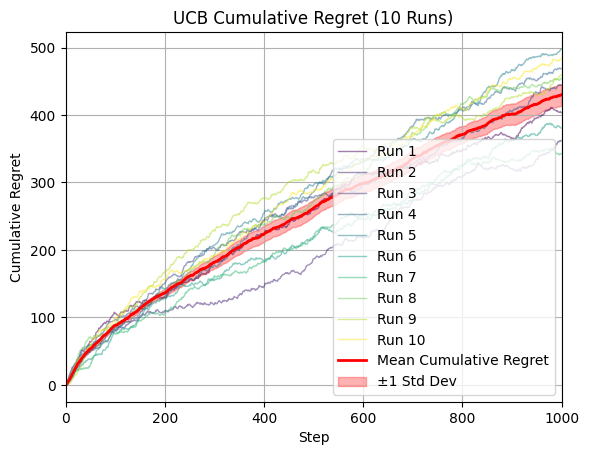

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Load data
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_csv('movies.dat', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# Extract the primary genre for each movie
movies['PrimaryGenre'] = movies['Genres'].str.split('|').str[0]

# Merge ratings and movies datasets
merged_data = pd.merge(ratings, movies, on='MovieID')

# Select Rating and PrimaryGenre columns
rating_genres_data = merged_data[['Rating', 'PrimaryGenre']]

# Get all unique genres
unique_genres = rating_genres_data['PrimaryGenre'].unique()

# Group by genres and create a dictionary to store ratings for each genre
genre_ratings = {genre: rating_genres_data[rating_genres_data['PrimaryGenre'] == genre]['Rating'].tolist() for genre in unique_genres}

# Calculate B: the difference between the maximum and minimum movie ratings
B = ratings['Rating'].max() - ratings['Rating'].min()

# UCB strategy
def ucb_bandit(K, n, reward_lists, B, l=1.0):
    np.random.seed(int(time.time()))
    random.seed(time.time())
    
    rewards, choices, regrets = [], [], []  # To record the reward, chosen arm, and regret at each step
    empirical_means = np.zeros(K)  # To record the empirical mean reward for each arm
    action_counts = np.zeros(K)  # To record the number of times each arm has been chosen
    cumulative_regrets = np.zeros(n)  # To record the cumulative regret at each step
    
    # UCB algorithm
    for t in range(1, n + 1):
        # Calculate the UCB value for each arm using the formula: UCB_i(t-1) = μ_i + B/2 * sqrt((l * ln(t)) / T_i(t-1))
        ucb_values = empirical_means + (B / 2) * np.sqrt((l * np.log(t)) / (action_counts + 1e-5))
        arm = np.argmax(ucb_values)  # Choose the arm with the highest UCB value
        r = random.choice(reward_lists[arm])  # Randomly select a reward from the chosen arm's reward list
        
        rewards.append(r)  # Record the reward for this step
        choices.append(arm)  # Record the chosen arm for this step
        action_counts[arm] += 1  # Update the count of the chosen arm
        empirical_means[arm] = (empirical_means[arm] * (action_counts[arm] - 1) + r) / action_counts[arm]  # Update the empirical mean reward
        
        # Calculate the regret for this step
        best_arm_mean = np.max(empirical_means)  # Find the arm with the highest empirical mean reward
        regrets.append(best_arm_mean - r)  # Calculate the regret for this step
        cumulative_regrets[t - 1] = np.sum(regrets)  # Calculate the cumulative regret
    
    return cumulative_regrets

# Example parameters
K = len(unique_genres)  # Number of arms (primary genres)
n = 10000  # Total time steps
reward_lists = list(genre_ratings.values())  # Use all genres' ratings as reward lists

# Run UCB ten times
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))

# Use different colors for each run
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

for run in range(num_runs):
    cumulative_regrets = ucb_bandit(K, n, reward_lists, B, l=2)
    all_cumulative_regrets[run, :] = cumulative_regrets
    plt.plot(cumulative_regrets, color=colors[run], alpha=0.5, linewidth=1, label=f'Run {run + 1}')

# Calculate average cumulative regret and standard deviation
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = std_cumulative_regrets / np.sqrt(num_runs)

# Plot average cumulative regret and error bars
plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n), 
                 mean_cumulative_regrets - stderr_cumulative_regrets, 
                 mean_cumulative_regrets + stderr_cumulative_regrets, 
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('UCB Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()